<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap20/20_4_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 20.4: Adversarial attacks**

This notebook builds uses the network for classification of MNIST from Notebook 10.5.  The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist, and uses the fast gradient sign attack of [Goodfellow et al. (2015)](https://arxiv.org/abs/1412.6572).  Having trained, the network, we search for adversarial examples -- inputs which look very similar to class A, but are mistakenly classified as class B.  We do this by starting with a correctly classified example and perturbing it according to the gradients of the network so that the output changes.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
# We first set the batch sizes for training and testing. Batch size refers to the number of samples
# processed before the model is updated. 
batch_size_train = 64 # The batch size for the training data
batch_size_test = 1000 # The batch size for the testing data

# Here, we are loading the MNIST dataset for training purposes.
# MNIST is a dataset of handwritten digits, widely used for training and testing in the field of machine learning.

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True, # Download MNIST dataset for training
                             transform=torchvision.transforms.Compose([ # Convert images to PyTorch tensors
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) # Normalize the images are these nyumbers arespecific to the MNIST dataset. 
                                                       # They represent the global mean and standard deviation of the MNIST dataset images
                             ])),
  batch_size=batch_size_train, shuffle=True)  # Set batch size and enable shuffling of the data

test_loader = torch.utils.data.DataLoader(  # Download MNIST dataset for testing
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([  # Convert images to PyTorch tensors
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) # Normalize the images are these nyumbers arespecific to the MNIST dataset. 
                                                       # They represent the global mean and standard deviation of the MNIST dataset images
                             ])),
  batch_size=batch_size_test, shuffle=True) # Set batch size and enable shuffling of the data

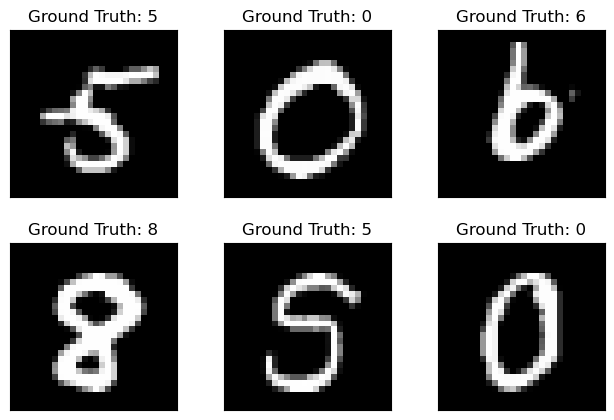

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [4]:
from os import X_OK

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the first convolutional layer
        # nn.Conv2d creates a 2D convolutional layer
        # 1 input channel (image): for grayscale images like those in MNIST
        # 10 output channels (filters): the number of filters applied to the input
        # kernel_size=5: size of each filter (5x5)        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)        
        
        # Define the second convolutional layer        
        # Input: 10 channels (output from conv1)
        # Output: 20 channels (filters)
        # kernel_size=5: using 5x5 filters again
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        # Dropout layer: Regularization technique to prevent overfitting
        # Randomly zeroes whole channels of the input tensor
        # The dropout rate is set to 0.5 (default) during training
        self.drop = nn.Dropout2d()
        
        # First Fully Connected (Linear) Layer
        # 320 input features: This comes from the output dimension of the last convolutional layer
        # 50 output features: Arbitrarily chosen, can be tuned
        self.fc1 = nn.Linear(320, 50)
        
        # Second Fully Connected (Linear) Layer
        # Reduces the output from 50 features to 10 features
        # In a classification task (like MNIST), this would correspond to 10 classes       
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
       # Forward pass defines how the input tensor flows through the model

       # Applying the first convolutional layer
        x = self.conv1(x)
        
        # Apply max pooling with a 2x2 window and ReLU activation function
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        
        # Applying the second convolutional layer
        x = self.conv2(x)
        
        # Apply dropout
        x = self.drop(x)
        
        # Apply max pooling with a 2x2 window and ReLU activation function
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        
        # Flatten the output for the fully connected layer
        x = x.flatten(1)
        
        # Apply the first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Apply log softmax activation function
        x = F.log_softmax(x, -1)
        
        return x

In [5]:
# Function to initialize weights
def weights_init(layer_in):
    # Check if the layer is an instance of nn.Linear (fully connected layer)
    if isinstance(layer_in, nn.Linear):
        # Apply He (Kaiming) uniform initialization to the weights
        # This is particularly good for layers followed by ReLU activations
        # It considers the size of the previous layer to maintain a variance
        # that helps in avoiding the vanishing/exploding gradients problem
        nn.init.kaiming_uniform_(layer_in.weight)
        
        
        # Initialize the biases to be zero
        # It's a common practice to start with zero biases, as the He initialization
        # is primarily concerned with the weights. Starting with zero biases ensures
        # that the neurons start in the non-activated state in the case of ReLU.
        layer_in.bias.data.fill_(0.0)

In [6]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

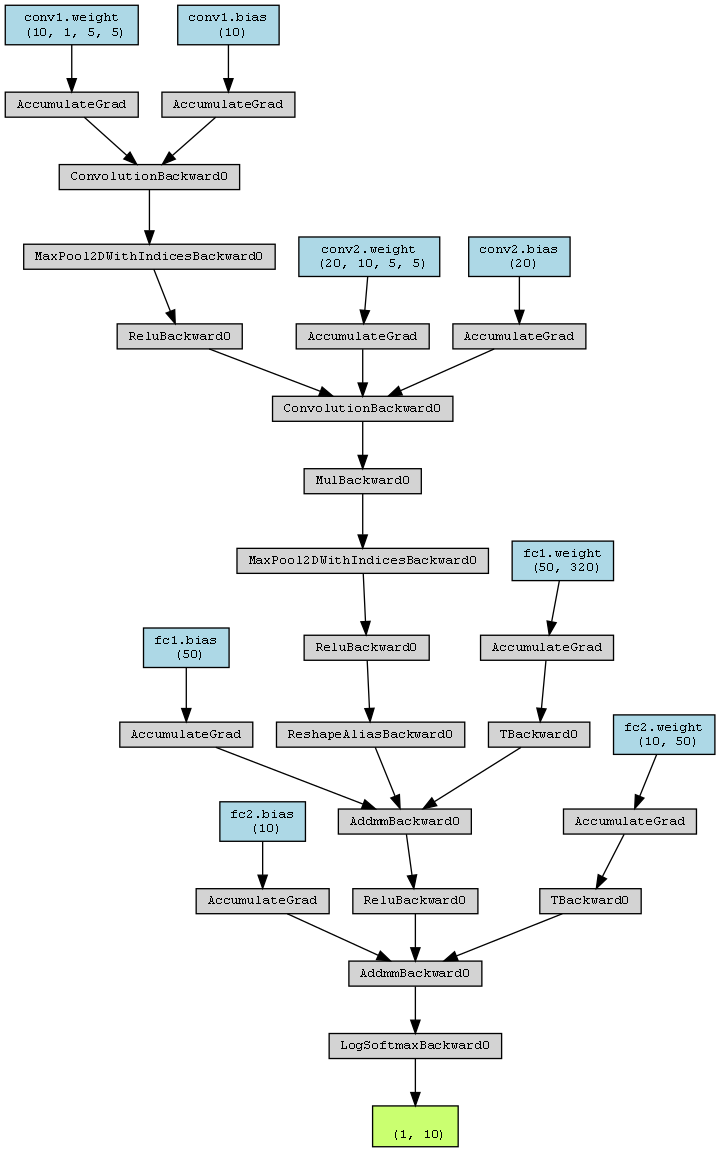

In [7]:
from torchviz import make_dot
from IPython.display import Image

# Generate a dummy input that matches the input shape expected by your model.
# For the MNIST dataset, each image is grayscale and 28x28 pixels, 
# hence the shape (1, 1, 28, 28) - 1 sample, 1 channel, 28x28 pixels.
dummy_input = torch.randn(1, 1, 28, 28)

# Forward pass: Run the dummy input through the model to get a sample output.
# This step is necessary as it allows torchviz to trace the operations and 
# build the computation graph.
output = model(dummy_input)

# Visualization of the computation graph:
# make_dot creates a graph from the output tensor of your model.
# The graph reflects the operations (like convolutions, activations) that the input tensor undergoes
# within the model to transform it into the output tensor.
# params=dict(model.named_parameters()) includes parameter names in the graph,
# making it easier to associate each operation with the corresponding layer.
viz = make_dot(output, params=dict(model.named_parameters()))

# To render and view the graph, use 'render' or 'view' method
viz.format = 'png'
file = viz.render("model_architecture", format="png", view=True)  # Saves the graph as a PNG file
viz.view()  # Opens the graph for viewing (might not work in all environments)
Image(file)

In [8]:
# Main training routine
def train(epoch):
    # Set the model to training mode. This is important as certain layers like
    # dropout layers behave differently during training compared to testing.
    model.train()    
    
    # Iterate over batches of data in train_loader.
    # train_loader is a DataLoader object that loads the data and labels in batches.
    # 'enumerate' is used to keep track of the batch index.    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero the gradients computed in the previous iteration.
        # This is necessary because gradients accumulate by default.
        optimizer.zero_grad()
        
        # Forward pass: compute the model output (predictions) for the data (batch of images).
        output = model(data)
        
        # Compute the loss between the output and the ground truth labels.
        # F.nll_loss is Negative Log Likelihood loss, typically used for classification with log_softmax.
        loss = F.nll_loss(output, target)
        # Backward pass: compute the gradients of the loss with respect to model parameters.
        loss.backward()
        # Update model parameters (weights and biases) using the computed gradients.
        optimizer.step()
        
        # Logging and monitoring: print the loss every 10 batches.
        # This helps in tracking the training progress.
        if batch_idx % 10 == 0:
          print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [9]:
# Run on test data
def test():
    # Set the model to evaluation mode. This is important because some layers like
    # dropout and batch normalization behave differently during evaluation.
    model.eval()

    # Initialize variables to track the test loss and the number of correct predictions.
    test_loss = 0
    correct = 0

    # Disable gradient computations. Since we are only doing forward passes during testing,
    # gradients are not needed and disabling them reduces memory usage and speeds up computations.
    with torch.no_grad():
        # Iterate over the test data (test_loader contains batches of test data and labels).
        for data, target in test_loader:
            # Forward pass: compute the model output for the test data.
            output = model(data)
            
            # Accumulate the test loss by summing up losses across all batches.
            # F.nll_loss is Negative Log Likelihood loss.
            # We set size_average=False to sum the losses instead of averaging,
            # so later we can divide by the total number of items for the average loss.
            test_loss += F.nll_loss(output, target, size_average=False).item()
            
            # Get the index of the max log-probability as the prediction.
            pred = output.data.max(1, keepdim=True)[1]
    
            # Count the number of correct predictions.
            correct += pred.eq(target.data.view_as(pred)).sum()
        # Calculate the average loss over the total number of items in the test dataset.
        test_loss /= len(test_loader.dataset)
        print(f'\nTest set: Avg. loss: {test_loss:.4f},\
        'f'Accuracy: {correct}/{len(test_loader.dataset)} 'f'({100. * correct / len(test_loader.dataset):.0f}%)')

In [10]:
# Test the performance of the model before any training.
# This helps to understand the baseline performance of the model.
# It's useful to know how the model performs with its initial weights,
# which might be random or set by some weight initialization method.
test()

# Set the number of epochs for training.
# An epoch is one complete pass through the entire training dataset.
n_epochs = 3

for epoch in range(1, n_epochs + 1):
    # Train the model for one epoch.
    # During each epoch, the model learns by adjusting its weights
    # based on the current training dataset. 
    train(epoch)
    test()

C:\ProgramData\Anaconda3\envs\Disclosure_det\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4581,        Accuracy: 895/10000 (9%)
Train Epoch: 1 [0/60000]	Loss: 2.643231
Train Epoch: 1 [640/60000]	Loss: 2.199032
Train Epoch: 1 [1280/60000]	Loss: 2.241997
Train Epoch: 1 [1920/60000]	Loss: 2.174236
Train Epoch: 1 [2560/60000]	Loss: 1.893526
Train Epoch: 1 [3200/60000]	Loss: 1.693660
Train Epoch: 1 [3840/60000]	Loss: 1.686476
Train Epoch: 1 [4480/60000]	Loss: 1.368968
Train Epoch: 1 [5120/60000]	Loss: 1.096880
Train Epoch: 1 [5760/60000]	Loss: 1.009529
Train Epoch: 1 [6400/60000]	Loss: 0.931673
Train Epoch: 1 [7040/60000]	Loss: 1.036535
Train Epoch: 1 [7680/60000]	Loss: 0.983160
Train Epoch: 1 [8320/60000]	Loss: 0.770796
Train Epoch: 1 [8960/60000]	Loss: 0.776291
Train Epoch: 1 [9600/60000]	Loss: 0.521638
Train Epoch: 1 [10240/60000]	Loss: 0.619887
Train Epoch: 1 [10880/60000]	Loss: 0.532681
Train Epoch: 1 [11520/60000]	Loss: 0.413822
Train Epoch: 1 [12160/60000]	Loss: 0.680723
Train Epoch: 1 [12800/60000]	Loss: 0.397278
Train Epoch: 1 [13440/60000]	Loss:

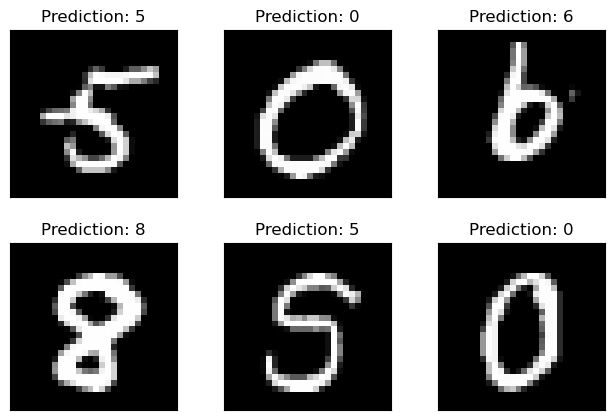

In [11]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

This is the code that does the adversarial attack. It is adapted from [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html).   It is an example of the fast gradient sign method (FGSM), which modifies the data by



*   Calculating the derivative $\partial L/\partial \mathbf{x}$ of the loss $L$ with respect to the input data $\mathbf{x}$.
*   Finds the sign of the gradient at each point (making a tensor the same size as $\mathbf{x}$ with a one where it was positive and minus one where it was negative.  
*   Multiplying this vector by $\epsilon$ and adding it back to the original data




In [12]:
# FGSM attack code.
def fgsm_attack(x, epsilon, dLdx):
    # Get the sign of the gradient of the loss with respect to the input image.
    # The sign function ensures we take the largest step (controlled by epsilon) 
    # in the direction that increases the loss.
    sign_dLdx = dLdx.sign()
    
    # Add epsilon times the sign of the gradient to the input image.
    # This creates the adversarial image by perturbing the original image 
    # in the direction that maximizes the loss.
    x_modified = x + epsilon * sign_dLdx

    # Clip the resulting image to ensure its values are between 0 and 1
    # (assuming the input x is normalized in this range).
    # This step is necessary because the added perturbation might lead to
    # some values falling outside the valid image range.
    x_modified = torch.clamp(x_modified, 0, 1)

    # Return the perturbed image
    return x_modified

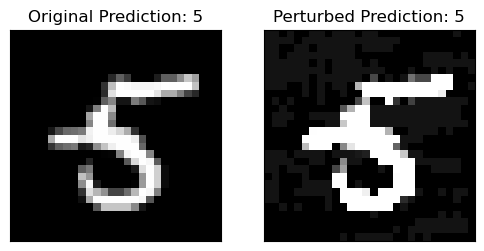

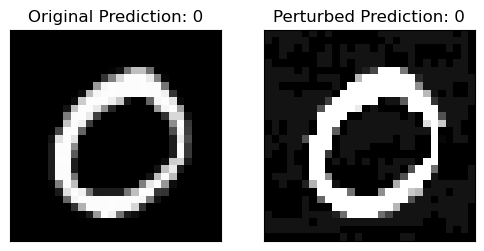

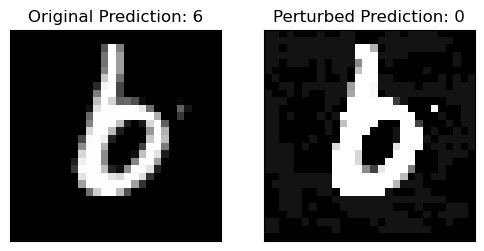

In [17]:
# Number of examples to run the FGSM attack on
no_examples = 3
epsilon = 0.5  # Perturbation factor

# Loop over the number of examples
for i in range(no_examples):
    # Reset gradients
    optimizer.zero_grad()

    # Get the i'th data example
    x = example_data[i].unsqueeze(0)  # Add an extra dimension at the beginning
    x.requires_grad = True

    # Get the i'th target
    y = torch.tensor([example_targets[i]], dtype=torch.long)

    # Run the model
    output = model(x)

    # Compute the loss
    loss = F.nll_loss(output, y)

    # Back propagate
    model.zero_grad()  # Zero all existing gradients
    loss.backward()

    # Collect `dLdx`
    dLdx = x.grad.data

    # Call FGSM Attack
    x_prime = fgsm_attack(x, epsilon, dLdx)

    # Re-classify the perturbed image
    output_prime = model(x_prime)

    # Visualizing the original and perturbed images
    plt.figure(figsize=(6, 3))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Original Prediction: {output.max(1)[1].item()}")
    plt.xticks([])
    plt.yticks([])

    # Perturbed Image
    plt.subplot(1, 2, 2)
    plt.imshow(x_prime[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
    plt.title(f"Perturbed Prediction: {output_prime.max(1)[1].item()}")
    plt.xticks([])
    plt.yticks([])

    plt.show()

Although we have only added a small amount of noise, the model is fooled into thinking that these images come from a different class.

In [14]:
def iterative_fgsm_attack(x, y, epsilon, num_steps):
    x_perturbed = x.clone().detach()  # Clone the original input
    x_perturbed.requires_grad = True

    for _ in range(num_steps):
        output = model(x_perturbed)
        model.zero_grad()
        loss = F.nll_loss(output, y)
        loss.backward()

        # Update x_perturbed
        with torch.no_grad():
            x_perturbed += epsilon * x_perturbed.grad.sign()
            x_perturbed = torch.clamp(x_perturbed, 0, 1)

        # Re-enable gradient computation for the next iteration
        x_perturbed.requires_grad = True

    return x_perturbed


In [15]:
def apply_iterative_fgsm_and_visualize(num_examples, epsilon, num_steps):
    """
    Apply the iterative FGSM attack on a specified number of examples and visualize the results.

    :param num_examples: Number of examples to process.
    :param epsilon: Step size for each iteration of the FGSM attack.
    :param num_steps: Number of steps for the FGSM attack.
    """
    for i in range(num_examples):
        # Get the i-th example
        x, y = example_data[i].unsqueeze(0), torch.tensor([example_targets[i]], dtype=torch.long)

        # Perform the iterative FGSM attack
        x_perturbed = iterative_fgsm_attack(x, y, epsilon, num_steps)

        # Run the model on both original and perturbed images
        output = model(x)
        output_perturbed = model(x_perturbed)

        # Visualization
        plt.figure(figsize=(6, 3))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
        plt.title(f"Original Prediction: {output.max(1)[1].item()}")
        plt.xticks([])
        plt.yticks([])

        # Perturbed Image
        plt.subplot(1, 2, 2)
        plt.imshow(x_perturbed[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')
        plt.title(f"Perturbed Prediction: {output_perturbed.max(1)[1].item()}")
        plt.xticks([])
        plt.yticks([])

        plt.show()


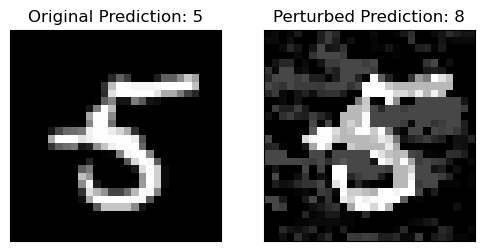

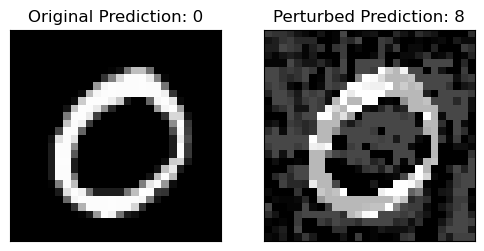

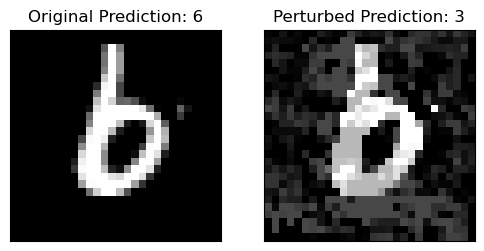

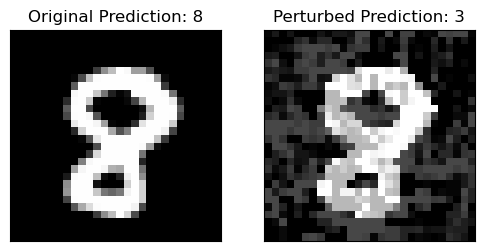

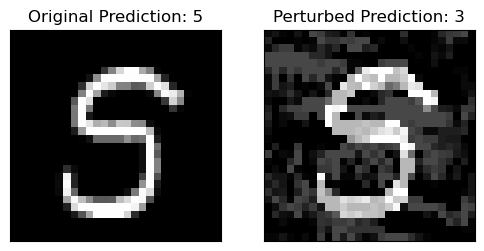

In [16]:
num_examples = 5  # Number of examples to process
epsilon = 0.02    # Perturbation factor for each attack step
num_steps = 15    # Number of steps in the FGSM attack

apply_iterative_fgsm_and_visualize(num_examples, epsilon, num_steps)
